<a href="https://colab.research.google.com/github/MAHMUDURRAHMANARNOB/HIT140_assessment2/blob/main/Bat%26Rat_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [93]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

File paths

In [94]:
INPUT1 = "/content/dataset1.csv"
INPUT2 = "/content/dataset2.csv"
OUT1 = "/content/clean_dataset1.csv"
OUT2 = "/content/clean_dataset2.csv"

safe read CSV

In [95]:
def safe_read_csv(path):
    """Read CSV robustly and return dataframe. If file missing, raise helpful error."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Input file not found: {path}")
    return pd.read_csv(path, low_memory=False)

Load raw data

In [96]:
df1 = safe_read_csv(INPUT1)
df2 = safe_read_csv(INPUT2)
print("Raw shapes:", "dataset1:", df1.shape, "dataset2:", df2.shape)

Raw shapes: dataset1: (907, 12) dataset2: (2123, 7)


Remove fully-empty rows
Reason: trailing blank rows or placeholder rows can create many NaNs.
Use dropna(how='all') so we keep rows with any useful data.

In [97]:
df1 = df1.dropna(how="all").reset_index(drop=True)
df2 = df2.dropna(how="all").reset_index(drop=True)
print("After dropping fully-empty rows:", "dataset1:", df1.shape, "dataset2:", df2.shape)

After dropping fully-empty rows: dataset1: (907, 12) dataset2: (2123, 7)


Handle missing values
Numeric → fill with median (robust to outliers)
Categorical/text → fill with "unknown"

In [98]:
for col in df1.select_dtypes(include=["float64", "int64"]).columns:
    df1[col] = df1[col].fillna(df1[col].median())

for col in df1.select_dtypes(include=["object"]).columns:
    df1[col] = df1[col].fillna("unknown")

for col in df2.select_dtypes(include=["float64", "int64"]).columns:
    df2[col] = df2[col].fillna(df2[col].median())

for col in df2.select_dtypes(include=["object"]).columns:
    df2[col] = df2[col].fillna("unknown")

Parse datetime columns
Important: data appears in day-first format (DD/MM/YYYY HH:MM) -> use dayfirst=True
We'll keep both original and parsed columns (suffix _parsed).

In [99]:
time_cols_df1 = ["start_time", "rat_period_start", "rat_period_end", "sunset_time"]
for col in time_cols_df1:
    if col in df1.columns:
        df1[col + "_parsed"] = pd.to_datetime(df1[col], dayfirst=True, errors="coerce")

if "time" in df2.columns:
    df2["time_parsed"] = pd.to_datetime(df2["time"], dayfirst=True, errors="coerce")

Convert numeric columns safely
Coerce non-numeric strings to NaN so we can handle them consistently.

In [100]:
num_cols_df1 = ["bat_landing_to_food", "seconds_after_rat_arrival", "risk", "reward", "month", "hours_after_sunset"]
for c in num_cols_df1:
    if c in df1.columns:
        df1[c] = pd.to_numeric(df1[c], errors="coerce")

num_cols_df2 = ["month", "hours_after_sunset", "bat_landing_number", "food_availability", "rat_minutes", "rat_arrival_number"]
for c in num_cols_df2:
    if c in df2.columns:
        df2[c] = pd.to_numeric(df2[c], errors="coerce")

Check outliers
Example: negative values in hours_after_sunset may mean "before sunset"
We don’t delete them, just flag them for later inspection.

In [101]:
if "hours_after_sunset" in df1.columns:
    df1["hours_after_sunset_outlier"] = df1["hours_after_sunset"] < 0

if "hours_after_sunset" in df2.columns:
    df2["hours_after_sunset_outlier"] = df2["hours_after_sunset"] < 0

Clean textual/categorical columns (habit)
Normalize text, strip whitespace, lower-case to reduce category proliferation.

In [102]:
if "habit" in df1.columns:
    df1["habit_clean"] = df1["habit"].astype(str).str.strip().str.lower()
    df1.loc[df1["habit_clean"].isin(["nan", "none", "none."]), "habit_clean"] = np.nan

Standardize months & seasons
Use meteorological seasons mapping (DJF, MAM, JJA, SON)

In [103]:
season_map = {
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "autumn", 10: "autumn", 11: "autumn"
}

if "start_time_parsed" in df1.columns:
    df1["month_inferred"] = df1["start_time_parsed"].dt.month
    df1["season_inferred"] = df1["month_inferred"].map(season_map)

if "time_parsed" in df2.columns:
    df2["month_inferred"] = df2["time_parsed"].dt.month
    df2["season_inferred"] = df2["month_inferred"].map(season_map)

Validate/derive time-based measures
Example: for dataset1, compare recorded seconds_after_rat_arrival with computed difference

In [104]:
if {"start_time_parsed", "rat_period_start_parsed"}.issubset(df1.columns):
    df1["sec_from_ratstart_calc"] = (
        df1["start_time_parsed"] - df1["rat_period_start_parsed"]
    ).dt.total_seconds()
    df1["sec_mismatch"] = df1["sec_from_ratstart_calc"] - df1["seconds_after_rat_arrival"]

Convert boolean/binary flags to safe dtypes
Use pandas nullable integer dtype (Int64) to preserve NaNs if present

In [105]:
for col in ["risk", "reward"]:
    if col in df1.columns:
        df1[col] = df1[col].astype("Int64")

for col in ["rat_arrival_number", "bat_landing_number"]:
    if col in df2.columns:
        df2[col] = df2[col].astype("Int64")

Remove duplicates (if any)

In [106]:
df1 = df1.drop_duplicates().reset_index(drop=True)
df2 = df2.drop_duplicates().reset_index(drop=True)

 Example safe imputation (documented & conservative)
If rat_minutes == 0 and rat_arrival_number is NaN -> set arrivals = 0

In [107]:
mask = (df2["rat_minutes"].notna()) & (df2["rat_minutes"] == 0) & (df2["rat_arrival_number"].isna())
if mask.any():
    df2.loc[mask, "rat_arrival_number"] = 0

Save cleaned outputs

In [108]:
df1.to_csv(OUT1, index=False)
df2.to_csv(OUT2, index=False)

 Short summary printouts

In [109]:
print("CLEANED dataset1 shape:", df1.shape)
print("CLEANED dataset2 shape:", df2.shape)
print("\nMissing per column (dataset1):\n", df1.isna().sum())
print("\nMissing per column (dataset2):\n", df2.isna().sum())

CLEANED dataset1 shape: (906, 22)
CLEANED dataset2 shape: (2123, 11)

Missing per column (dataset1):
 start_time                    0
bat_landing_to_food           0
habit                         0
rat_period_start              0
rat_period_end                0
seconds_after_rat_arrival     0
risk                          0
reward                        0
month                         0
sunset_time                   0
hours_after_sunset            0
season                        0
start_time_parsed             0
rat_period_start_parsed       0
rat_period_end_parsed         0
sunset_time_parsed            0
hours_after_sunset_outlier    0
habit_clean                   0
month_inferred                0
season_inferred               0
sec_from_ratstart_calc        0
sec_mismatch                  0
dtype: int64

Missing per column (dataset2):
 time                          0
month                         0
hours_after_sunset            0
bat_landing_number            0
food_availability   

**Exploratory Data Analysis(EDA)**

In [110]:
df1.describe()

,bat_landing_to_food,seconds_after_rat_arrival,risk,reward,month,hours_after_sunset,season,start_time_parsed,rat_period_start_parsed,rat_period_end_parsed,sunset_time_parsed,month_inferred,sec_from_ratstart_calc,sec_mismatch
count,906.000000,906.000000,906.0,906.0,906.000000,906.000000,906.000000,906,906,906,906,906.000000,906.000000,906.000000
mean,11.720544,282.786976,0.494481,0.534216,3.800221,5.532579,0.833333,2018-04-11 20:15:47.417218560,2018-04-11 20:11:03.841059328,2018-04-11 20:20:14.569536256,2018-04-11 14:44:19.801324544,4.144592,283.576159,0.789183
min,0.010238,0.000000,0.0,0.0,0.000000,-0.261667,0.000000,2017-12-26 20:57:00,2017-12-26 20:53:00,2017-12-26 20:58:00,2017-12-26 16:43:00,1.000000,0.000000,-57.000000
25%,1.000000,89.250000,0.0,0.0,4.000000,3.775069,1.000000,2018-04-03 23:29:00,2018-04-03 23:24:00,2018-04-03 23:40:00,2018-04-03 19:01:00,4.000000,60.000000,-17.000000
50%,4.000000,206.000000,0.0,1.0,4.000000,5.627083,1.000000,2018-04-27 00:27:30,2018-04-27 00:24:00,2018-04-27 00:28:00,2018-04-26 19:17:00,4.000000,180.000000,-1.000000
75%,11.750000,447.250000,1.0,1.0,5.000000,7.406250,1.000000,2018-05-01 00:07:45,2018-05-01 00:06:00,2018-05-01 00:09:00,2018-04-30 19:20:00,5.000000,420.000000,20.000000
max,443.000000,949.000000,1.0,1.0,5.000000,12.091944,1.000000,2018-05-31 23:34:00,2018-05-31 23:31:00,2018-05-31 23:34:00,2018-05-31 19:41:00,12.000000,960.000000,58.000000
std,27.658777,241.092545,0.500246,0.499103,1.199834,2.415383,0.372884,NaN,NaN,NaN,NaN,1.684528,243.799604,24.914322


In [111]:
df2.describe()

,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,time_parsed,month_inferred
count,2123.000000,2123.000000,2123.0,2123.000000,2123.000000,2123.0,2123,2123.000000
mean,3.083844,5.265426,32.083373,2.445874,1.994442,0.444654,2018-03-19 17:54:20.970324992,3.965615
min,0.000000,-2.000000,0.0,0.000000,0.000000,0.0,2017-12-26 16:13:00,1.000000
25%,2.000000,2.000000,11.0,1.962206,0.000000,0.0,2018-02-06 01:03:00,2.000000
50%,4.000000,5.000000,27.0,2.951877,0.000000,0.0,2018-04-04 05:01:00,4.000000
75%,4.000000,8.500000,48.0,3.105873,0.158333,1.0,2018-04-30 23:35:00,5.000000
max,6.000000,13.500000,178.0,4.000000,120.000000,17.0,2018-06-01 05:41:00,12.000000
std,1.642261,4.076188,25.614431,1.218353,6.793397,1.019195,NaN,2.657879


In [112]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   start_time                  906 non-null    object        
 1   bat_landing_to_food         906 non-null    float64       
 2   habit                       906 non-null    object        
 3   rat_period_start            906 non-null    object        
 4   rat_period_end              906 non-null    object        
 5   seconds_after_rat_arrival   906 non-null    int64         
 6   risk                        906 non-null    Int64         
 7   reward                      906 non-null    Int64         
 8   month                       906 non-null    int64         
 9   sunset_time                 906 non-null    object        
 10  hours_after_sunset          906 non-null    float64       
 11  season                      906 non-null    int64         

In [113]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2123 non-null   object        
 1   month                       2123 non-null   int64         
 2   hours_after_sunset          2123 non-null   float64       
 3   bat_landing_number          2123 non-null   Int64         
 4   food_availability           2123 non-null   float64       
 5   rat_minutes                 2123 non-null   float64       
 6   rat_arrival_number          2123 non-null   Int64         
 7   time_parsed                 2123 non-null   datetime64[ns]
 8   hours_after_sunset_outlier  2123 non-null   bool          
 9   month_inferred              2123 non-null   int32         
 10  season_inferred             2123 non-null   object        
dtypes: Int64(2), bool(1), datetime64[ns](1), float64(3), int

In [114]:
# Check the number of unique value in all columns of data1
df1.nunique()

,0
start_time,628
bat_landing_to_food,204
habit,82
rat_period_start,268
rat_period_end,268
seconds_after_rat_arrival,501
risk,2
reward,2
month,6
sunset_time,65


In [115]:
# Check the number of unique value in all columns of data2
df2.nunique()

,0
time,2123
month,7
hours_after_sunset,32
bat_landing_number,119
food_availability,600
rat_minutes,401
rat_arrival_number,10
time_parsed,2123
hours_after_sunset_outlier,2
month_inferred,7


In [116]:
# Correlations
corr_df1 = df1[['bat_landing_to_food', 'seconds_after_rat_arrival', 'risk', 'reward', 'hours_after_sunset']].corr()
print("\nCorrelation in Dataset1:\n", corr_df1)


Correlation in Dataset1:
                            bat_landing_to_food  seconds_after_rat_arrival  \
bat_landing_to_food                   1.000000                   0.025747   
seconds_after_rat_arrival             0.025747                   1.000000   
risk                                  0.168108                   0.021773   
reward                                0.007509                  -0.023516   
hours_after_sunset                   -0.033460                   0.077215   

                               risk    reward  hours_after_sunset  
bat_landing_to_food        0.168108  0.007509           -0.033460  
seconds_after_rat_arrival  0.021773 -0.023516            0.077215  
risk                       1.000000 -0.625473           -0.059072  
reward                    -0.625473  1.000000            0.052466  
hours_after_sunset        -0.059072  0.052466            1.000000  


<Axes: >

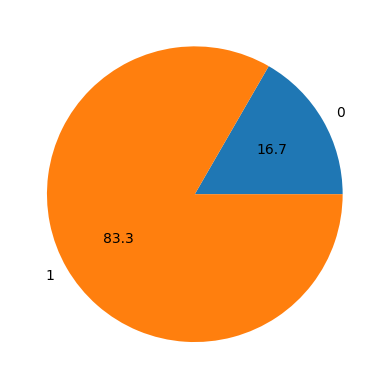

In [117]:
df1.groupby('season').size().plot(kind = 'pie', autopct = '%.1f')

<Axes: >

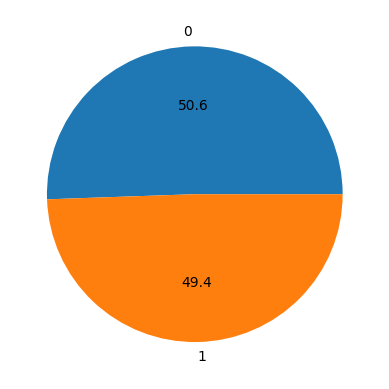

In [118]:
df1.groupby('risk').size().plot(kind = 'pie', autopct = '%.1f')

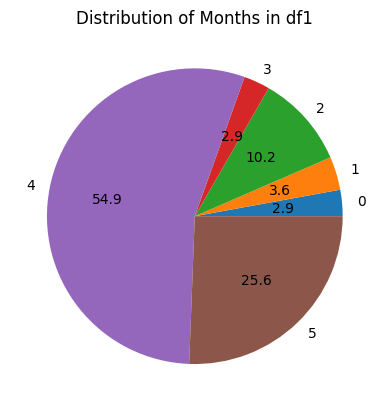

In [148]:
# 4. Create a pie chart for the 'month' column in df2
df1.groupby('month').size().plot(kind='pie', autopct='%.1f')
plt.title('Distribution of Months in df1')
plt.show()

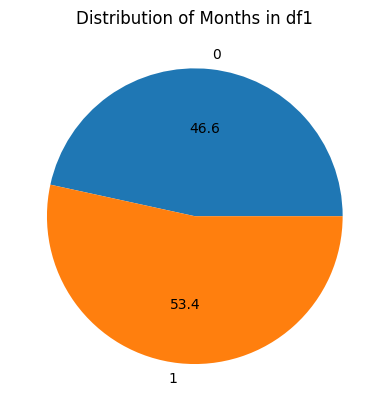

In [149]:
df1.groupby('reward').size().plot(kind = 'pie', autopct = '%.1f')
plt.title('Distribution of Months in df1')
plt.show()

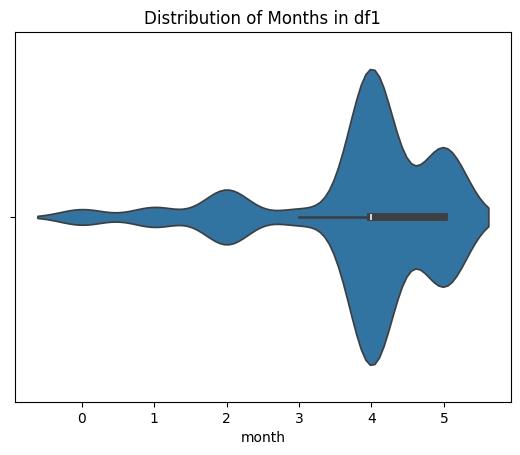

In [150]:
sns.violinplot(x = df1['month'])
plt.title('Distribution of Months in df1')
plt.show()

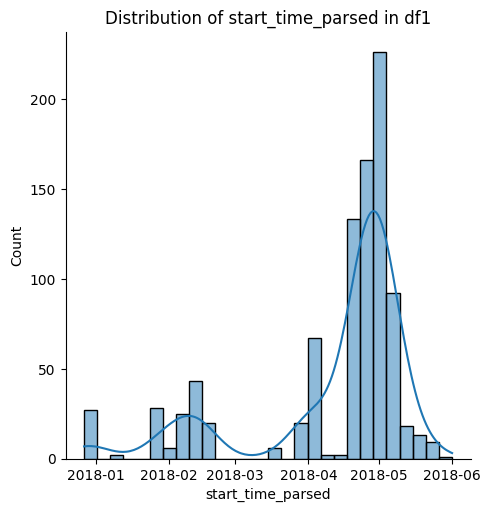

In [152]:
sns.displot(x ='start_time_parsed',data=df1,kde = 'True')
plt.title('Distribution of start_time_parsed in df1')
plt.show()

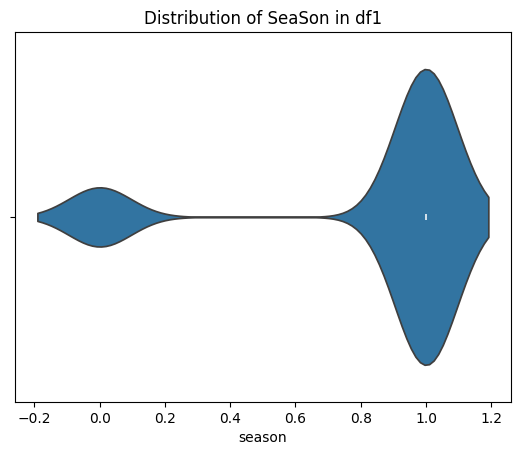

In [153]:
sns.violinplot(x = df1['season'])
plt.title('Distribution of SeaSon in df1')
plt.show()


<Axes: xlabel='month', ylabel='bat_landing_to_food'>

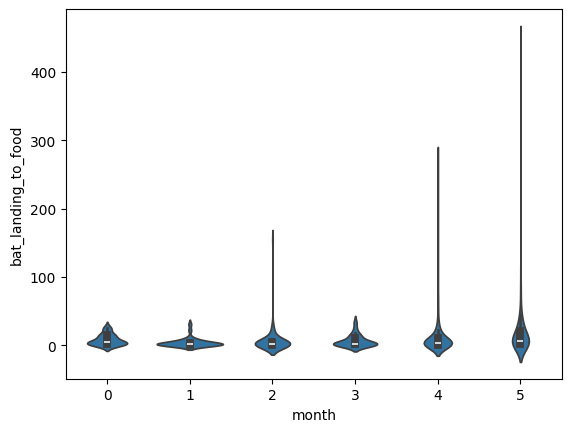

In [125]:
sns.violinplot(y = df1['bat_landing_to_food'], x = df1['month'])

<Axes: xlabel='risk', ylabel='bat_landing_to_food'>

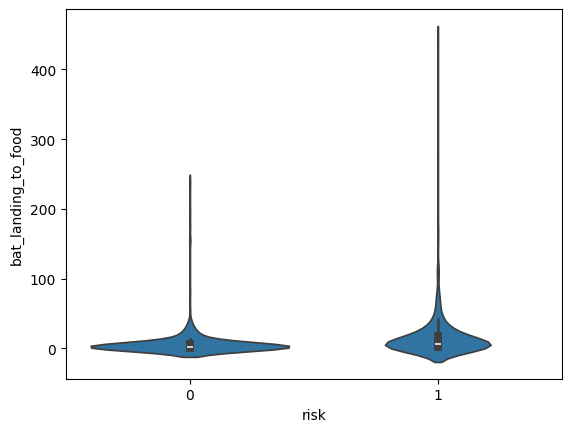

In [126]:
sns.violinplot(y = df1['bat_landing_to_food'], x = df1['risk'])

array([[<Axes: title={'center': 'bat_landing_to_food'}>,
        <Axes: title={'center': 'seconds_after_rat_arrival'}>,
        <Axes: title={'center': 'risk'}>,
        <Axes: title={'center': 'reward'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'hours_after_sunset'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'start_time_parsed'}>],
       [<Axes: title={'center': 'rat_period_start_parsed'}>,
        <Axes: title={'center': 'rat_period_end_parsed'}>,
        <Axes: title={'center': 'sunset_time_parsed'}>,
        <Axes: title={'center': 'month_inferred'}>],
       [<Axes: title={'center': 'sec_from_ratstart_calc'}>,
        <Axes: title={'center': 'sec_mismatch'}>, <Axes: >, <Axes: >]],
      dtype=object)

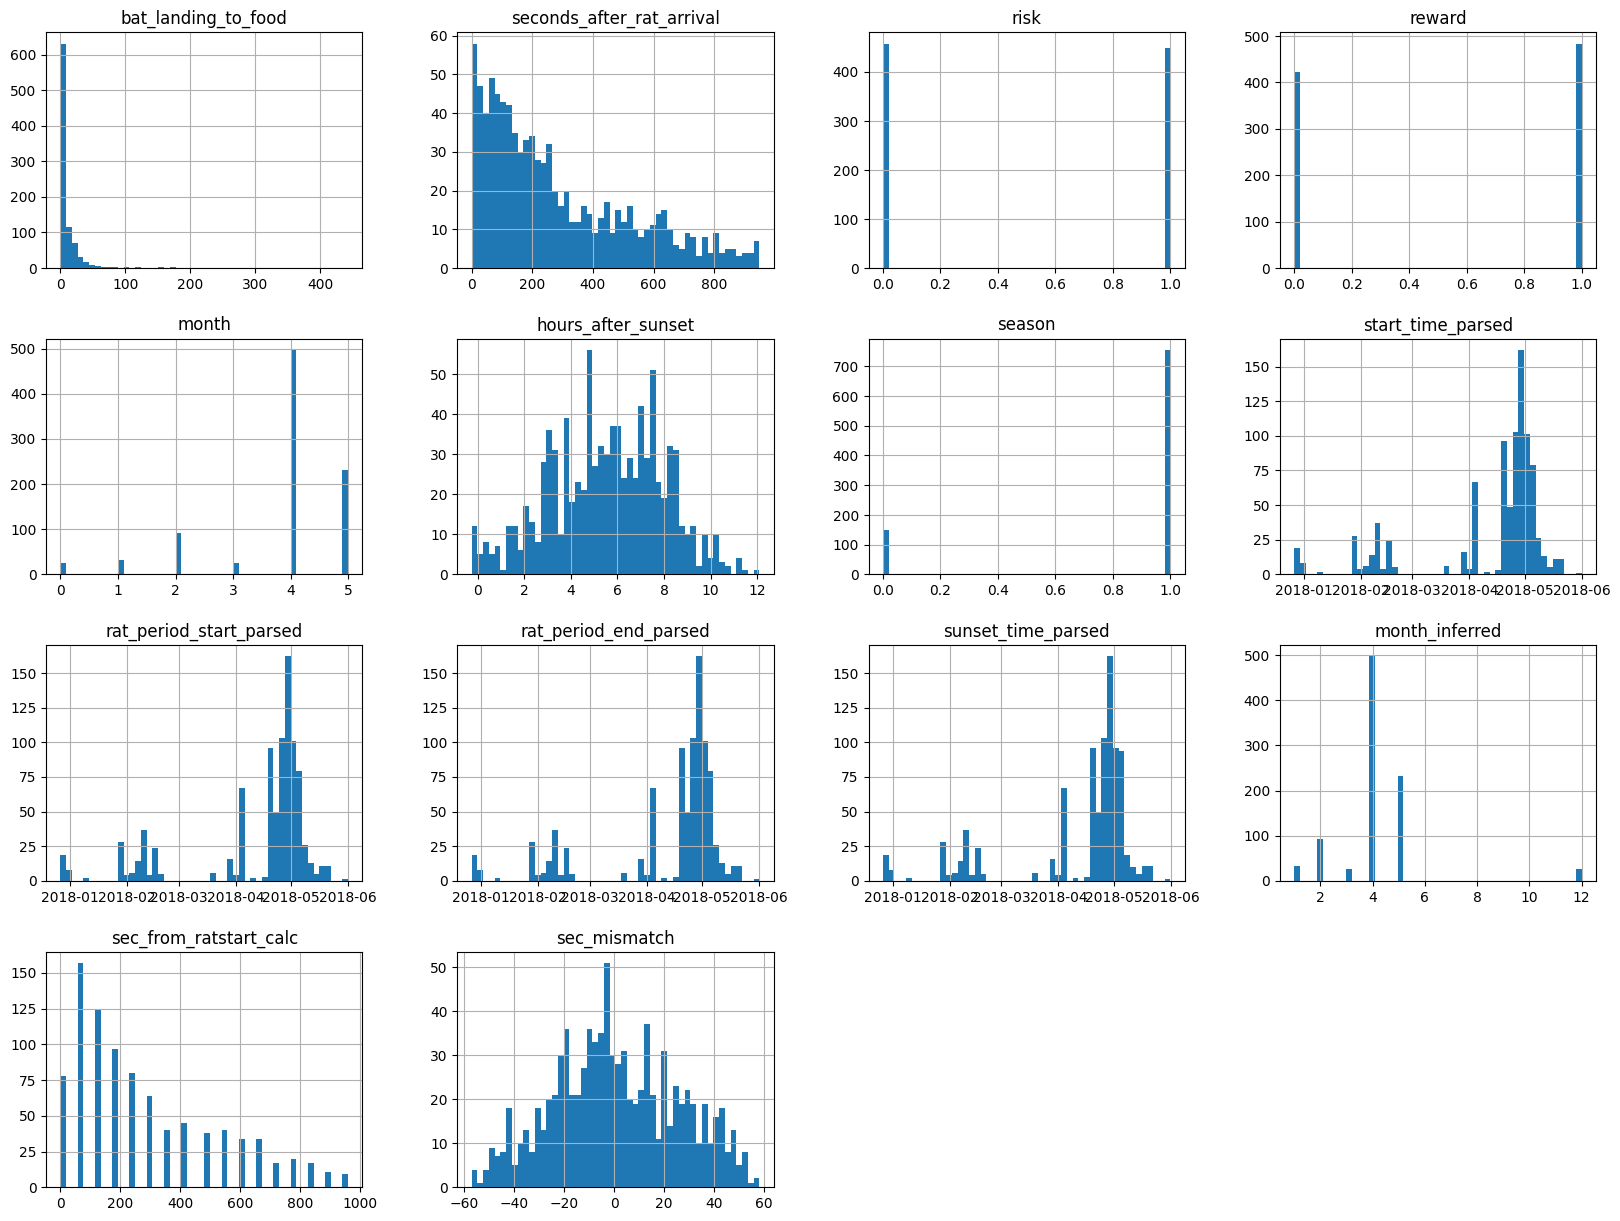

In [127]:
df1.hist (bins=50, figsize=(20,15))

ValueError: num must be an integer with 1 <= num <= 12, not 13

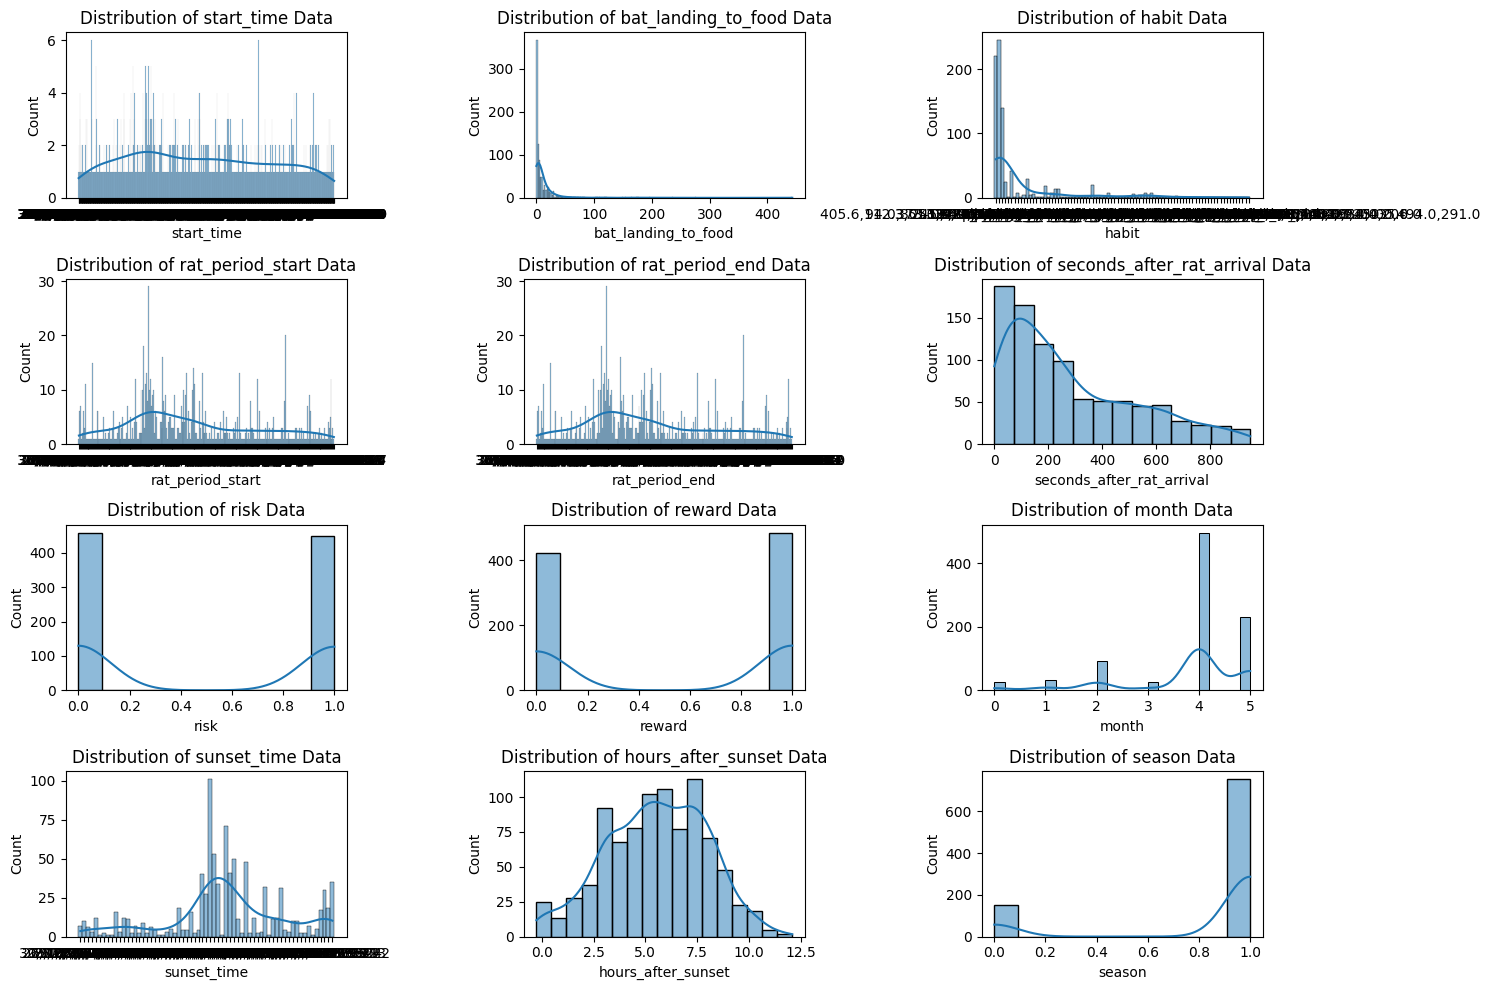

In [128]:
# Then we can check the linearity of the variables by plotting the distribution graph and looking for skewness of features.
plt.figure(figsize=(15,10))
for i,col in enumerate(df1.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df1[col],kde=True)
    plt.tight_layout()
    plt.plot()

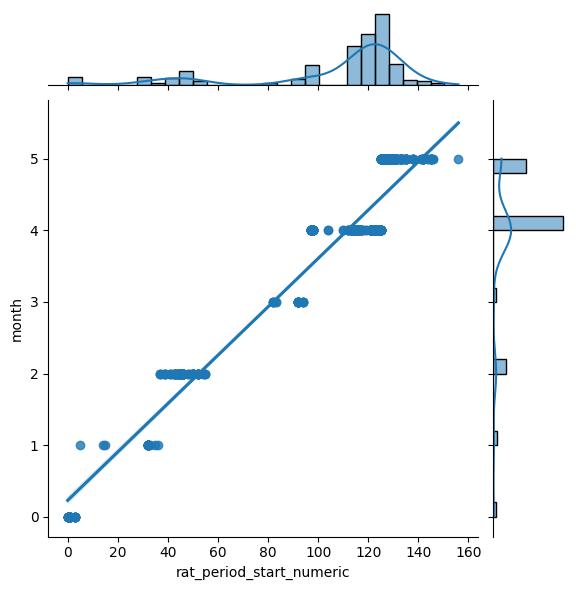

In [129]:
# Convert datetime to numerical representation for regression plot
# Use the parsed datetime column for calculations
df1['rat_period_start_numeric'] = (df1['rat_period_start_parsed'] - df1['rat_period_start_parsed'].min()).dt.days

sns.jointplot(x='rat_period_start_numeric', y='month', data=df1, kind='reg')

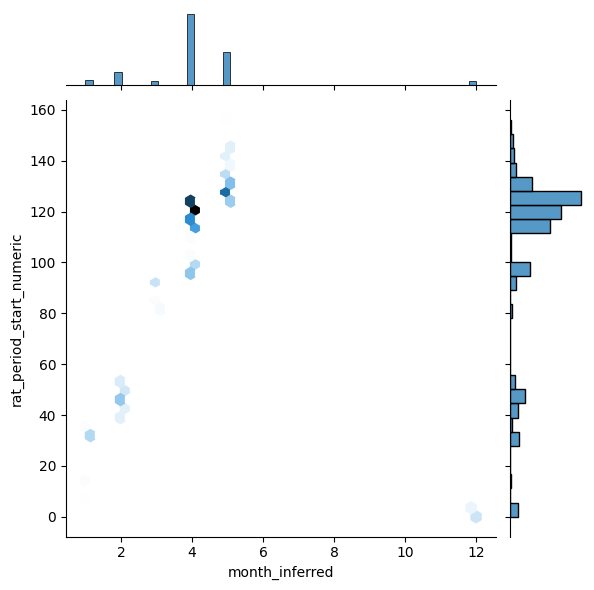

In [130]:
# Convert datetime to numerical representation for hex plot
# Use the parsed datetime column for calculations
df1['rat_period_start_numeric'] = (df1['rat_period_start_parsed'] - df1['rat_period_start_parsed'].min()).dt.days

# Use 'month_inferred' for the x-axis as it is numeric
sns.jointplot(x = 'month_inferred', y = 'rat_period_start_numeric', data = df1, kind = 'hex')

<Axes: >

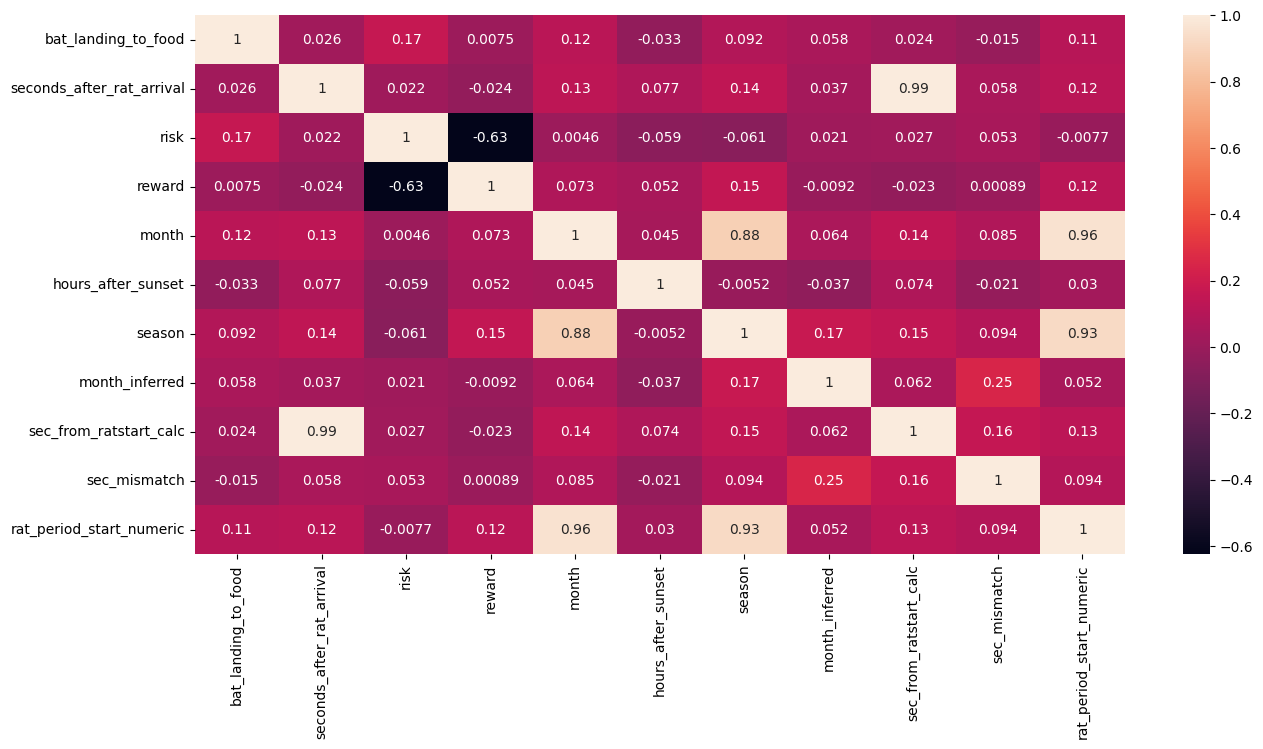

In [131]:
plt.figure(figsize=(15,7))
sns.heatmap(df1.select_dtypes(include=np.number).corr(),annot=True)

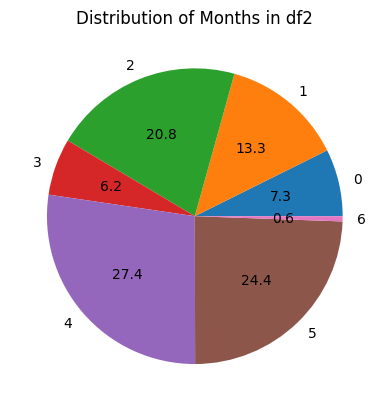

In [141]:
# 4. Create a pie chart for the 'month' column in df2
df2.groupby('month').size().plot(kind='pie', autopct='%.1f')
plt.title('Distribution of Months in df2')
plt.show()


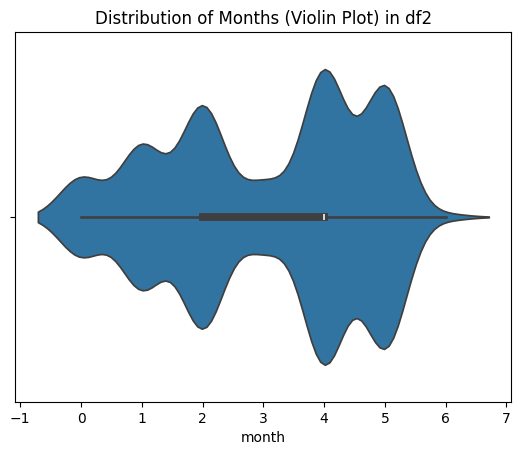

In [142]:
# 5. Generate a violin plot for the 'month' column in df2
sns.violinplot(x=df2['month'])
plt.title('Distribution of Months (Violin Plot) in df2')
plt.show()


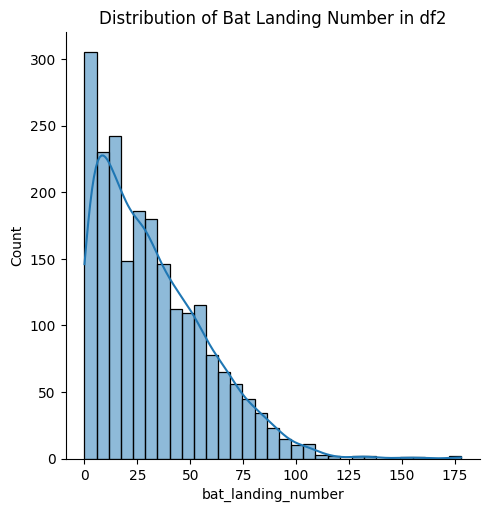

In [143]:
# 6. Create a distribution plot for 'bat_landing_number' in df2
sns.displot(x='bat_landing_number', data=df2, kde=True)
plt.title('Distribution of Bat Landing Number in df2')
plt.show()

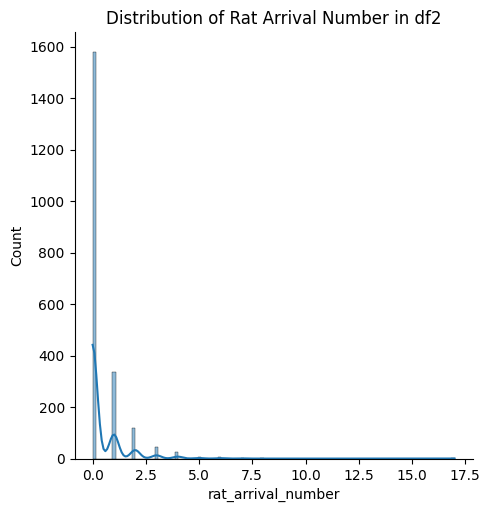

In [144]:
# 7. Create a distribution plot for 'rat_arrival_number' in df2
sns.displot(x='rat_arrival_number', data=df2, kde=True)
plt.title('Distribution of Rat Arrival Number in df2')
plt.show()


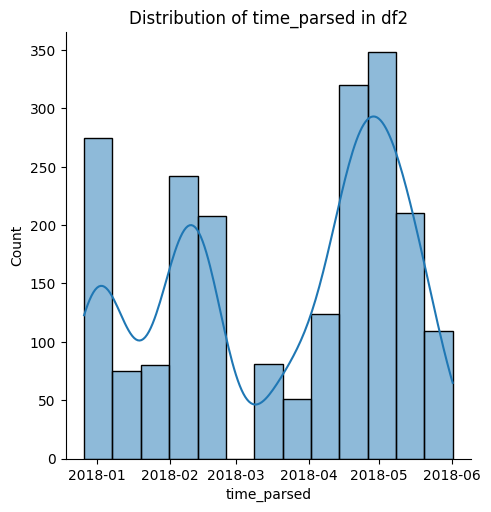

In [145]:
# 8. Create a distribution plot for 'time_parsed' in df2
sns.displot(x='time_parsed', data=df2, kde=True)
plt.title('Distribution of time_parsed in df2')
plt.show()

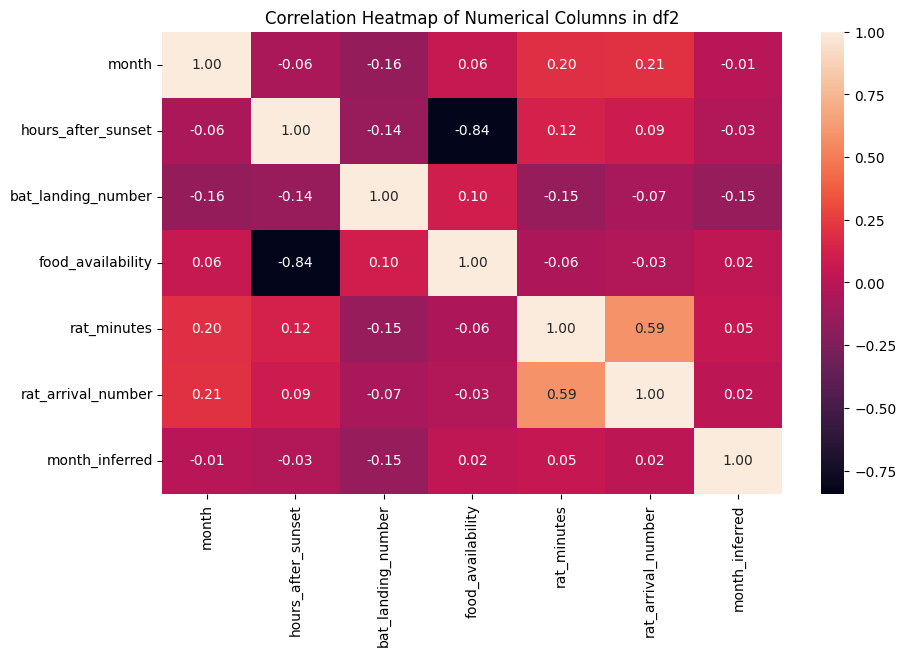

In [146]:
# 9. Generate a heatmap for correlations between numerical columns in df2
plt.figure(figsize=(10, 6))
sns.heatmap(df2.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns in df2')
plt.show()

,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,time_parsed,month_inferred
count,2123.000000,2123.000000,2123.0,2123.000000,2123.000000,2123.0,2123,2123.000000
mean,3.083844,5.265426,32.083373,2.445874,1.994442,0.444654,2018-03-19 17:54:20.970324992,3.965615
min,0.000000,-2.000000,0.0,0.000000,0.000000,0.0,2017-12-26 16:13:00,1.000000
25%,2.000000,2.000000,11.0,1.962206,0.000000,0.0,2018-02-06 01:03:00,2.000000
50%,4.000000,5.000000,27.0,2.951877,0.000000,0.0,2018-04-04 05:01:00,4.000000
75%,4.000000,8.500000,48.0,3.105873,0.158333,1.0,2018-04-30 23:35:00,5.000000
max,6.000000,13.500000,178.0,4.000000,120.000000,17.0,2018-06-01 05:41:00,12.000000
std,1.642261,4.076188,25.614431,1.218353,6.793397,1.019195,NaN,2.657879


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2123 non-null   object        
 1   month                       2123 non-null   int64         
 2   hours_after_sunset          2123 non-null   float64       
 3   bat_landing_number          2123 non-null   Int64         
 4   food_availability           2123 non-null   float64       
 5   rat_minutes                 2123 non-null   float64       
 6   rat_arrival_number          2123 non-null   Int64         
 7   time_parsed                 2123 non-null   datetime64[ns]
 8   hours_after_sunset_outlier  2123 non-null   bool          
 9   month_inferred              2123 non-null   int32         
 10  season_inferred             2123 non-null   object        
dtypes: Int64(2), bool(1), datetime64[ns](1), float64(3), int

None

,0
time,2123
month,7
hours_after_sunset,32
bat_landing_number,119
food_availability,600
rat_minutes,401
rat_arrival_number,10
time_parsed,2123
hours_after_sunset_outlier,2
month_inferred,7


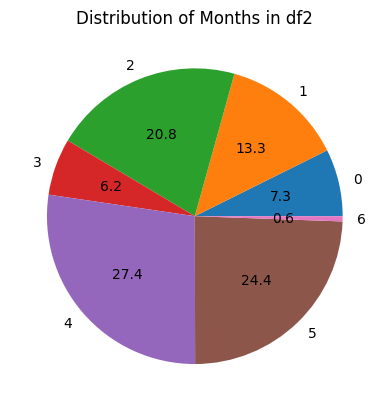

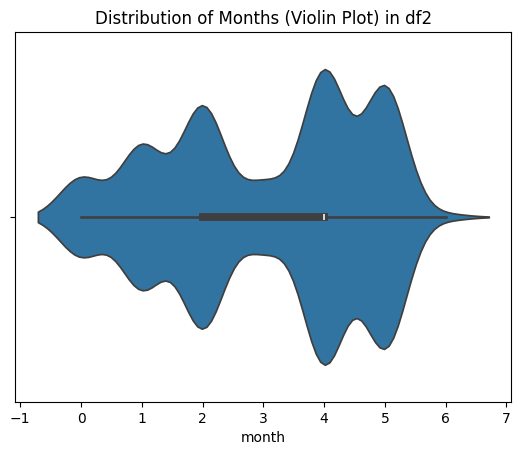

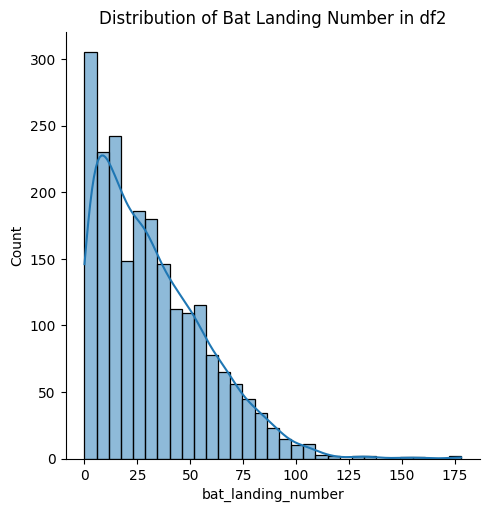

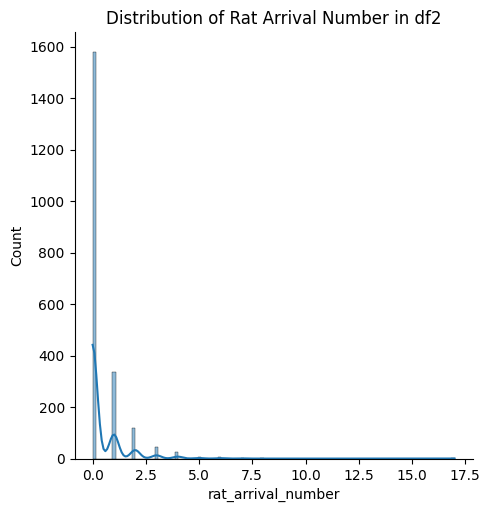

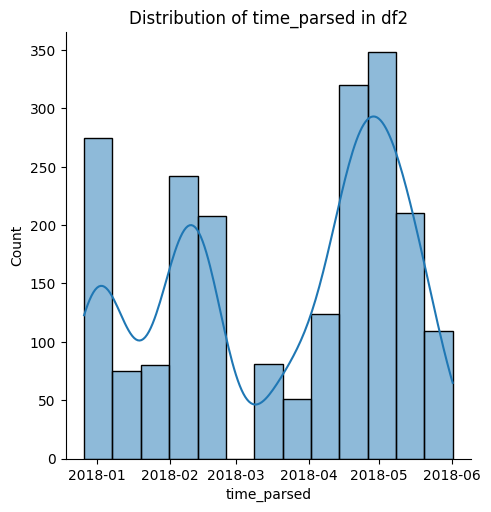

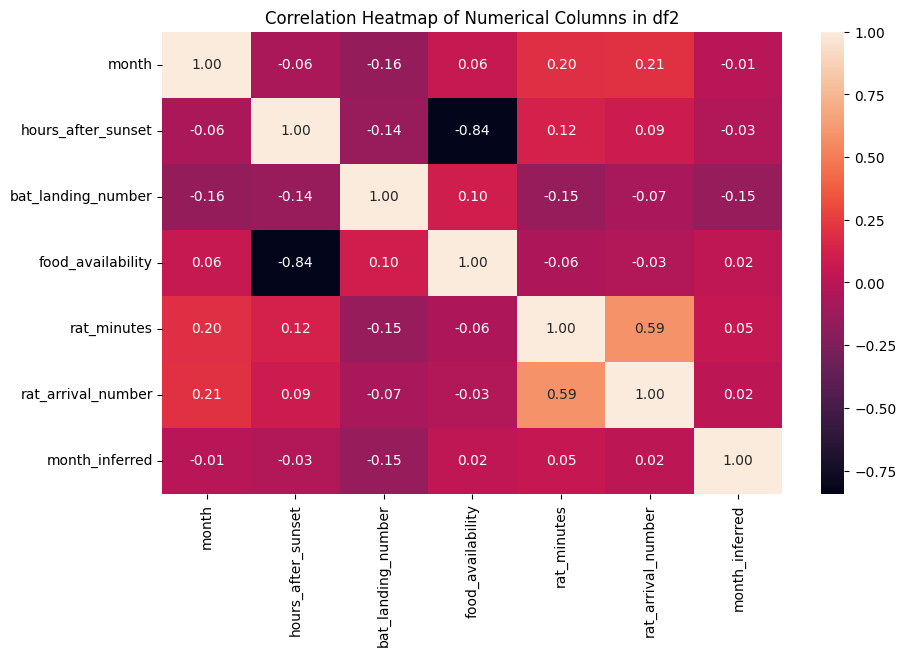

In [74]:
# 1. Display descriptive statistics of df2
display(df2.describe())

# 2. Display information about df2
display(df2.info())

# 3. Calculate and display unique value counts for each column in df2
display(df2.nunique())

# 4. Create a pie chart for the 'month' column in df2
df2.groupby('month').size().plot(kind='pie', autopct='%.1f')
plt.title('Distribution of Months in df2')
plt.show()

# 5. Generate a violin plot for the 'month' column in df2
sns.violinplot(x=df2['month'])
plt.title('Distribution of Months (Violin Plot) in df2')
plt.show()

# 6. Create a distribution plot for 'bat_landing_number' in df2
sns.displot(x='bat_landing_number', data=df2, kde=True)
plt.title('Distribution of Bat Landing Number in df2')
plt.show()

# 7. Create a distribution plot for 'rat_arrival_number' in df2
sns.displot(x='rat_arrival_number', data=df2, kde=True)
plt.title('Distribution of Rat Arrival Number in df2')
plt.show()

# 8. Create a distribution plot for 'time_parsed' in df2
sns.displot(x='time_parsed', data=df2, kde=True)
plt.title('Distribution of time_parsed in df2')
plt.show()

# 9. Generate a heatmap for correlations between numerical columns in df2
plt.figure(figsize=(10, 6))
sns.heatmap(df2.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns in df2')
plt.show()

## Compare and contrast findings from df1 and df2

### Subtask:
Identify similarities and differences in the characteristics of the two datasets based on the EDA. Consider if the data from `df1` and `df2` can be combined or used together for further analysis.


**Reasoning**:
I will compare the summary statistics, data types, distributions, and correlations of df1 and df2 to identify similarities and differences and assess if the data can be combined.



Summary Statistics - df1:


,bat_landing_to_food,seconds_after_rat_arrival,risk,reward,month,hours_after_sunset,season,start_time_parsed,rat_period_start_parsed,rat_period_end_parsed,sunset_time_parsed,month_inferred,sec_from_ratstart_calc,sec_mismatch,rat_period_start_numeric
count,906.000000,906.000000,906.0,906.0,906.000000,906.000000,906.000000,906,906,906,906,906.000000,906.000000,906.000000,906.000000
mean,11.720544,282.786976,0.494481,0.534216,3.800221,5.532579,0.833333,2018-04-11 20:15:47.417218560,2018-04-11 20:11:03.841059328,2018-04-11 20:20:14.569536256,2018-04-11 14:44:19.801324544,4.144592,283.576159,0.789183,105.721854
min,0.010238,0.000000,0.0,0.0,0.000000,-0.261667,0.000000,2017-12-26 20:57:00,2017-12-26 20:53:00,2017-12-26 20:58:00,2017-12-26 16:43:00,1.000000,0.000000,-57.000000,0.000000
25%,1.000000,89.250000,0.0,0.0,4.000000,3.775069,1.000000,2018-04-03 23:29:00,2018-04-03 23:24:00,2018-04-03 23:40:00,2018-04-03 19:01:00,4.000000,60.000000,-17.000000,98.000000
50%,4.000000,206.000000,0.0,1.0,4.000000,5.627083,1.000000,2018-04-27 00:27:30,2018-04-27 00:24:00,2018-04-27 00:28:00,2018-04-26 19:17:00,4.000000,180.000000,-1.000000,121.000000
75%,11.750000,447.250000,1.0,1.0,5.000000,7.406250,1.000000,2018-05-01 00:07:45,2018-05-01 00:06:00,2018-05-01 00:09:00,2018-04-30 19:20:00,5.000000,420.000000,20.000000,125.000000
max,443.000000,949.000000,1.0,1.0,5.000000,12.091944,1.000000,2018-05-31 23:34:00,2018-05-31 23:31:00,2018-05-31 23:34:00,2018-05-31 19:41:00,12.000000,960.000000,58.000000,156.000000
std,27.658777,241.092545,0.500246,0.499103,1.199834,2.415383,0.372884,NaN,NaN,NaN,NaN,1.684528,243.799604,24.914322,34.003021



Summary Statistics - df2:


,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,time_parsed,month_inferred
count,2123.000000,2123.000000,2123.0,2123.000000,2123.000000,2123.0,2123,2123.000000
mean,3.083844,5.265426,32.083373,2.445874,1.994442,0.444654,2018-03-19 17:54:20.970324992,3.965615
min,0.000000,-2.000000,0.0,0.000000,0.000000,0.0,2017-12-26 16:13:00,1.000000
25%,2.000000,2.000000,11.0,1.962206,0.000000,0.0,2018-02-06 01:03:00,2.000000
50%,4.000000,5.000000,27.0,2.951877,0.000000,0.0,2018-04-04 05:01:00,4.000000
75%,4.000000,8.500000,48.0,3.105873,0.158333,1.0,2018-04-30 23:35:00,5.000000
max,6.000000,13.500000,178.0,4.000000,120.000000,17.0,2018-06-01 05:41:00,12.000000
std,1.642261,4.076188,25.614431,1.218353,6.793397,1.019195,NaN,2.657879



Data Types - df1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   start_time                  906 non-null    object        
 1   bat_landing_to_food         906 non-null    float64       
 2   habit                       906 non-null    object        
 3   rat_period_start            906 non-null    object        
 4   rat_period_end              906 non-null    object        
 5   seconds_after_rat_arrival   906 non-null    int64         
 6   risk                        906 non-null    Int64         
 7   reward                      906 non-null    Int64         
 8   month                       906 non-null    int64         
 9   sunset_time                 906 non-null    object        
 10  hours_after_sunset          906 non-null    float64       
 11  season                      906 non-nul

None


Data Types - df2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2123 non-null   object        
 1   month                       2123 non-null   int64         
 2   hours_after_sunset          2123 non-null   float64       
 3   bat_landing_number          2123 non-null   Int64         
 4   food_availability           2123 non-null   float64       
 5   rat_minutes                 2123 non-null   float64       
 6   rat_arrival_number          2123 non-null   Int64         
 7   time_parsed                 2123 non-null   datetime64[ns]
 8   hours_after_sunset_outlier  2123 non-null   bool          
 9   month_inferred              2123 non-null   int32         
 10  season_inferred             2123 non-null   object        
dtypes: Int64(2), bool(1), datetime64[ns](

None


Distribution of 'month' - df1:


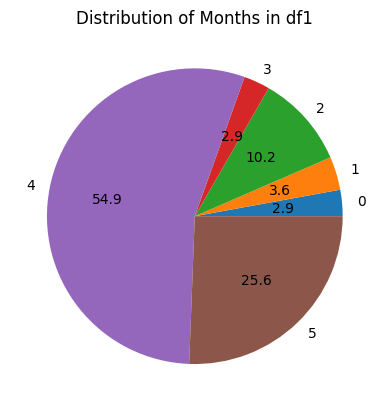


Distribution of 'month' - df2:


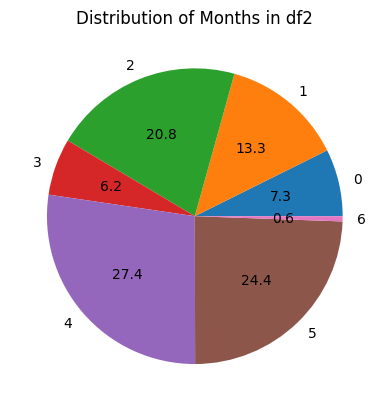


Distribution of 'hours_after_sunset' - df1:


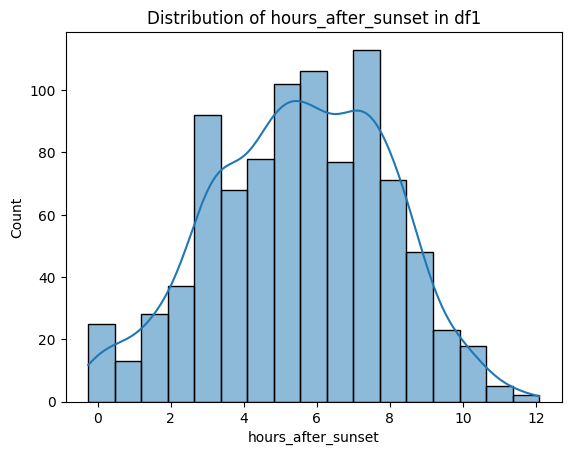


Distribution of 'hours_after_sunset' - df2:


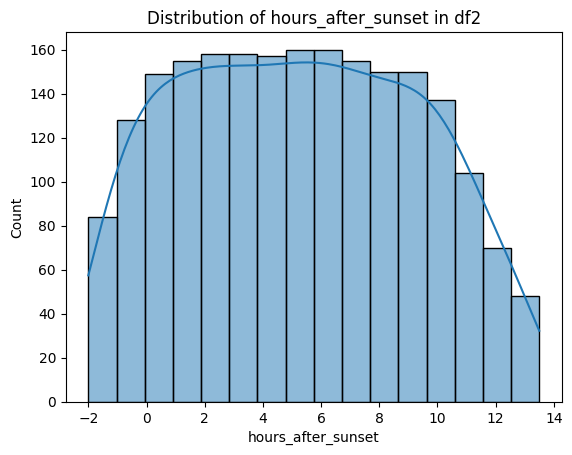


Correlation Heatmap - df1:


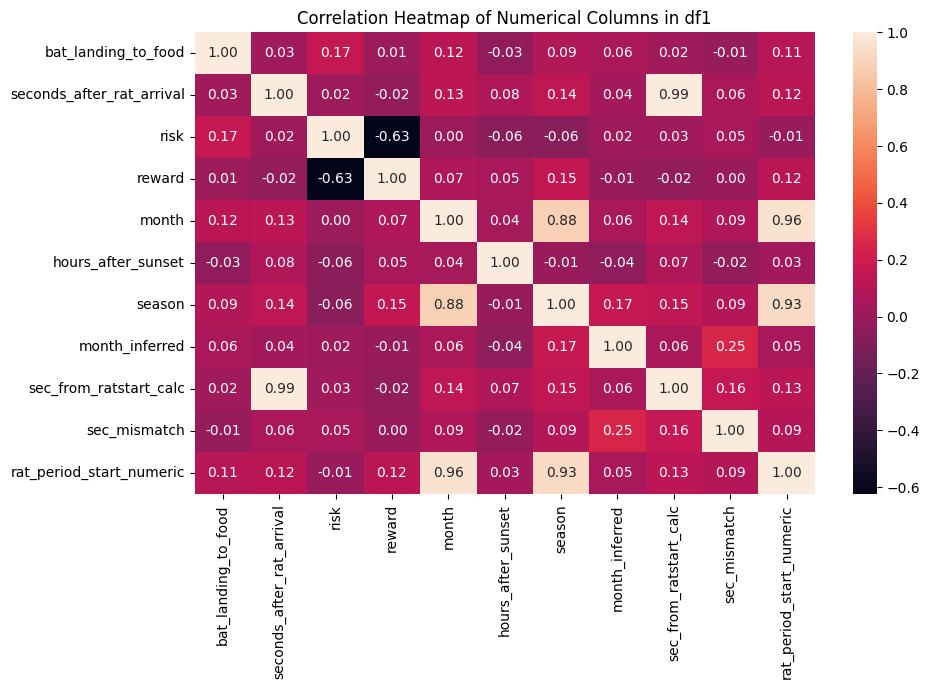


Correlation Heatmap - df2:


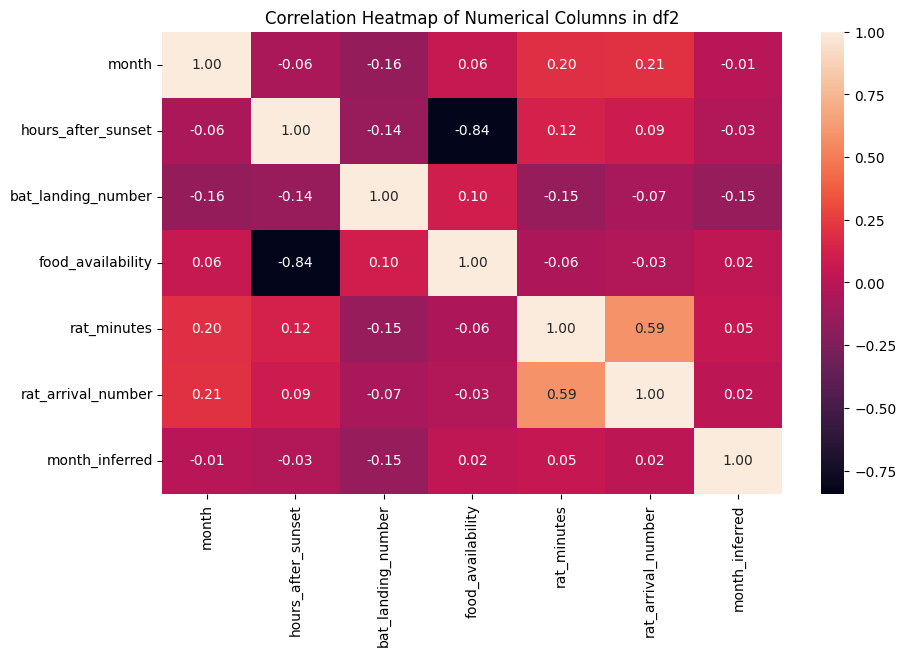

In [75]:
# Compare summary statistics
print("Summary Statistics - df1:")
display(df1.describe())
print("\nSummary Statistics - df2:")
display(df2.describe())

# Compare data types
print("\nData Types - df1:")
display(df1.info())
print("\nData Types - df2:")
display(df2.info())

# Compare distributions of 'month'
print("\nDistribution of 'month' - df1:")
df1.groupby('month').size().plot(kind='pie', autopct='%.1f')
plt.title('Distribution of Months in df1')
plt.show()

print("\nDistribution of 'month' - df2:")
df2.groupby('month').size().plot(kind='pie', autopct='%.1f')
plt.title('Distribution of Months in df2')
plt.show()

# Compare distributions of 'hours_after_sunset'
print("\nDistribution of 'hours_after_sunset' - df1:")
sns.histplot(df1['hours_after_sunset'], kde=True)
plt.title('Distribution of hours_after_sunset in df1')
plt.show()

print("\nDistribution of 'hours_after_sunset' - df2:")
sns.histplot(df2['hours_after_sunset'], kde=True)
plt.title('Distribution of hours_after_sunset in df2')
plt.show()

# Compare correlation heatmaps
print("\nCorrelation Heatmap - df1:")
plt.figure(figsize=(10, 6))
sns.heatmap(df1.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns in df1')
plt.show()

print("\nCorrelation Heatmap - df2:")
plt.figure(figsize=(10, 6))
sns.heatmap(df2.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns in df2')
plt.show()